<a href="https://colab.research.google.com/github/hpiyankov/FinInstrumentTimeSeries/blob/master/CryptoAnalyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Double check if we have GPU enabled



In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-02a542ab-1806-77fd-ce2d-ad4b102a9725)


In [2]:
!nvidia-smi

Tue Mar 12 15:37:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Install additional needed libraries

*   mat plot lib finance






In [3]:
!pip install mpl_finance

  Stored in directory: /root/.cache/pip/wheels/67/db/24/04ddd06ec9a5e4500b44c13d8e95898f5b90b512303e385de8
Successfully built mpl-finance


Api keys for nomics. We are loading them form google drive.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
with open('/content/gdrive/My Drive/9. HighAvailability/ColabKeys/nomics_api.txt', 'r') as f:
  api_key = f.read()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.finance import candlestick
# from matplotlib.finance import volume_overlay3
# finance module is no longer part of matplotlib
# see: https://github.com/matplotlib/mpl_finance
from mpl_finance import candlestick_ochl as candlestick
from mpl_finance import volume_overlay3
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import datetime

In [0]:
def fetch_data():
    response = requests.get('https://api.nomics.com/v1/candles?key='+api_key+'&currency=BTC')
    return response.json()

In [0]:
test = fetch_data()
df = pd.DataFrame(test)

In [15]:
df.head(5)

,close,high,low,open,timestamp,volume
0,14.58601,14.58601,14.53295,14.53737,2013-01-14T00:00:00Z,1805
1,14.47379,14.76857,14.47379,14.52479,2013-01-15T00:00:00Z,1939
2,15.02459,15.02460,14.74920,14.75878,2013-01-16T00:00:00Z,10127
3,15.96468,15.96468,15.09600,15.09600,2013-01-17T00:00:00Z,27334
4,15.99800,16.26278,15.74880,16.03437,2013-01-18T00:00:00Z,17294


In [0]:
time = pd.to_datetime(df['timestamp'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249 entries, 0 to 2248
Data columns (total 6 columns):
close        2249 non-null object
high         2249 non-null object
low          2249 non-null object
open         2249 non-null object
timestamp    2249 non-null object
volume       2249 non-null object
dtypes: object(6)
memory usage: 105.5+ KB


In [0]:
del df['timestamp']

In [19]:
df_conv = df.astype(float)
df_conv['time'] = time
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249 entries, 0 to 2248
Data columns (total 6 columns):
close     2249 non-null float64
high      2249 non-null float64
low       2249 non-null float64
open      2249 non-null float64
volume    2249 non-null float64
time      2249 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 105.5 KB


In [0]:
def plotOHLC(dframe):
    candlesticks = dframe[['open','high','low','close']].copy()
    candlesticks["time"] = dframe[['time']].copy().apply(date2num)
    candlesticks = candlesticks.astype(float)
    candlesticks.set_index('time')
  
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)

    ax.set_ylabel('Quote ($)', size=20)
    candlestick(ax, candlesticks.values,width=1,colorup='g', colordown='r')
    
    max = candlesticks['high'].max()
    ax.set_ylim(-max/2,max*1.1)
    ax.set_xlim(candlesticks['time'].min(), candlesticks['time'].max())
    
    xt = ax.get_xticks()
    new_xticks = [datetime.date.isoformat(num2date(d)) for d in xt]
    ax.set_xticklabels(new_xticks,rotation=45, horizontalalignment='right')
    size = ax.get_position()
    
    # create the second axis for the volume bar-plot
    ax2 = ax.twinx()
    
    # get data from candlesticks for a bar plot
    dates = candlesticks ["time"]
    volume = dframe['volume']

    # make bar plots and color differently depending on up/down for the day
    pos = candlesticks['open']-candlesticks['close']<0
    neg = candlesticks['open']-candlesticks['close']>0
    ax2.bar(dates[pos],volume[pos],color='green',width=1,align='center')
    ax2.bar(dates[neg],volume[neg],color='red',width=1,align='center')

    #scale the x-axis tight
    ax2.set_xlim(candlesticks['time'].min(), candlesticks['time'].max())
    ax2.set_ylim(volume.min(),volume.max()*3)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Volume', size=20)
    
    plt.show(block=True)

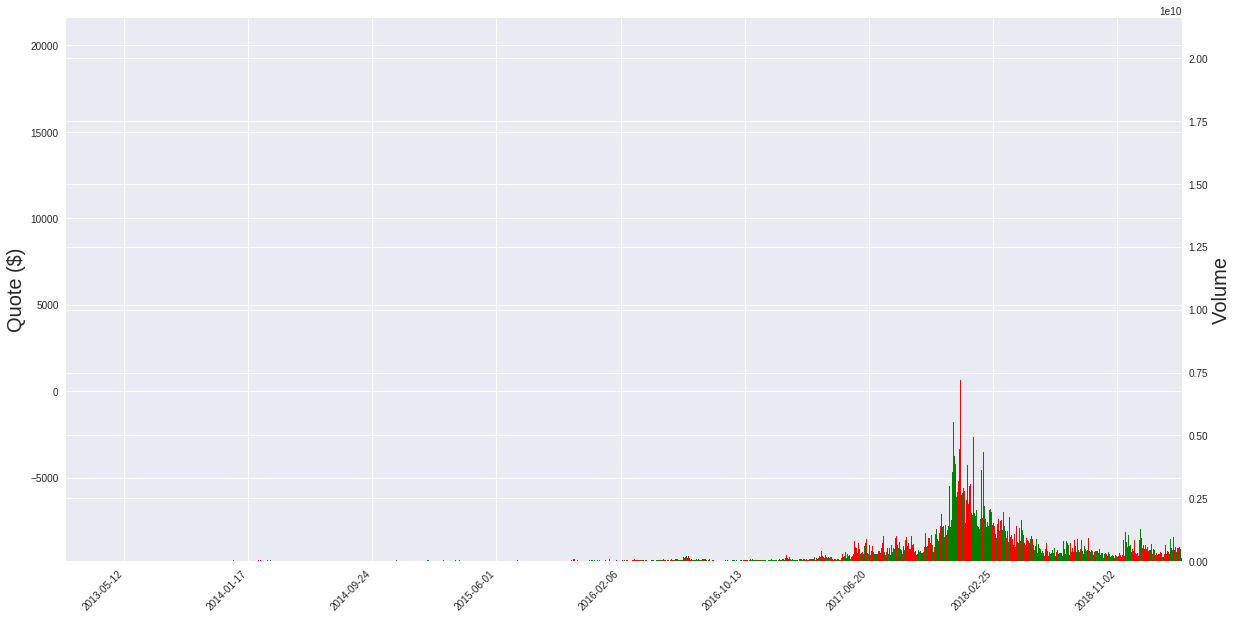

In [38]:
plotOHLC(df_conv)

In [0]:
plotOHLC(df_conv[:100])